# Importance to use the Trailed Source Magnitude For Your Analysis of Sorcha Output

Sorcha computes two magnitudes for each potential LSST discovery/detection chance: the trailed source magnitude and the PSF magnitude. The PSF magnitude is the apparent magnitude in a given filter measured by the data management pipelines assuming a stellar-like PSF. The trailed source magnitude is apparent magnitude in a given filter adding up all of the counts in the trail (as the simulated object is moving object). The PSF magnitude is what is used in detection by the Rubin transient soure detection pipelines, but the trailed source magnitude is the true apparent megnitude of the moving object.  

Sorcha can output both magnitudes, but by default will output only the trailed source magnitude. Other option options may output both values.  One must be careful use the correct apparent magnitude in your analysis. For anything invovling photometry (and not detectability), the recommend is to use the trailed soruce manigude. In this notebook, we show why it is important to use the trailed source magnitude.

Let's demonstrate the combined effect of including both the phase curve and the trailing loss for a main belt asteroid. 

This will using functionality from both the `demo_ApparentMagnitudeValidation` and `demo_TrailingLossesValidation` notebooks. 

In [1]:
import pandas as pd
import numpy as np
import astropy.units as u
from astroquery.jplhorizons import Horizons
from sorcha.modules.PPCalculateApparentMagnitudeInFilter import PPCalculateApparentMagnitudeInFilter
from sorcha.modules.PPTrailingLoss import PPTrailingLoss
import matplotlib.pyplot as plt

Let's grab two years of positions for asteroid Themis as expected from the Rubin Obervatory site (Obs Code X05)

In [2]:
obj = Horizons(id='Themis', id_type='name', location='X05',

               epochs={'start':'2021-01-01', 'stop':'2023-01-01',

                       'step':'1d'})

eph = obj.ephemerides(quantities='1,3,9,19,20,43')
jpl_eph = eph.to_pandas()
jpl_eph

,targetname,datetime_str,datetime_jd,H,G,solar_presence,lunar_presence,RA,DEC,RA_rate,DEC_rate,V,surfbright,r,r_rate,delta,delta_rate,alpha_true,PABLon,PABLat
0,24 Themis (A853 GA),2021-Jan-01 00:00,2459215.5,7.24,0.19,C,,264.58494,-23.75508,53.20329,-1.95622,13.318,7.112,3.275241,1.868767,4.212453,-4.641335,4.5918,262.7496,-0.4684
1,24 Themis (A853 GA),2021-Jan-02 00:00,2459216.5,7.24,0.19,C,,264.97017,-23.76944,53.12372,-1.81551,13.327,7.122,3.276319,1.866016,4.209518,-4.922561,4.7832,263.0067,-0.4700
2,24 Themis (A853 GA),2021-Jan-03 00:00,2459217.5,7.24,0.19,C,,265.35482,-23.78286,53.04133,-1.67544,13.335,7.132,3.277396,1.863252,4.206423,-5.203677,4.9741,263.2635,-0.4716
3,24 Themis (A853 GA),2021-Jan-04 00:00,2459218.5,7.24,0.19,C,,265.73886,-23.79534,52.95599,-1.53602,13.344,7.142,3.278471,1.860476,4.203166,-5.484746,5.1645,263.5200,-0.4732
4,24 Themis (A853 GA),2021-Jan-05 00:00,2459219.5,7.24,0.19,C,,266.12229,-23.80689,52.86754,-1.39727,13.352,7.152,3.279545,1.857687,4.199749,-5.765808,5.3543,263.7760,-0.4748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,24 Themis (A853 GA),2022-Dec-28 00:00,2459941.5,7.24,0.19,C,m,350.67588,-4.41353,28.87868,13.06346,13.480,7.626,3.407801,-1.337567,3.548593,23.738114,16.0868,357.7423,-0.3756
727,24 Themis (A853 GA),2022-Dec-29 00:00,2459942.5,7.24,0.19,C,m,350.87344,-4.32608,29.29327,13.24187,13.485,7.624,3.407028,-1.341288,3.562140,23.633121,16.0210,357.9249,-0.3731
728,24 Themis (A853 GA),2022-Dec-30 00:00,2459943.5,7.24,0.19,C,m,351.07368,-4.23745,29.70071,13.41729,13.491,7.621,3.406252,-1.345002,3.575623,23.523797,15.9522,358.1090,-0.3707
729,24 Themis (A853 GA),2022-Dec-31 00:00,2459944.5,7.24,0.19,C,m,351.27655,-4.14767,30.10119,13.58978,13.496,7.619,3.405474,-1.348708,3.589039,23.410351,15.8807,358.2945,-0.3683


In [3]:
observations_df = pd.DataFrame({'MJD':jpl_eph['datetime_jd'] - 2_400_000.5,
                                'H_filter': jpl_eph['H'],
                                'GS': jpl_eph['G'],
                                'Dec_deg' : np.zeros_like(jpl_eph['G']),
                                'G1': np.zeros(len(jpl_eph['G'])) + 0.62,
                                'G2': np.zeros(len(jpl_eph['G'])) + 0.14,
                                'G12': np.zeros(len(jpl_eph['G'])) + 0.68,
                                'JPL_mag': jpl_eph['V'],
                                'Range_LTC_km': jpl_eph['r'] * 1.495978707e8, #au to km
                                'Obj_Sun_LTC_km': jpl_eph['delta'] * 1.495978707e8,
                                'phase_deg': jpl_eph['alpha_true'],
                                'RARateCosDec_deg_day' : jpl_eph['RA_rate'] * 24/3600, # note horizons already applies the cos(dec) term 
                                'DecRate_deg_day' : jpl_eph['DEC_rate']* 24/3600,
                                'seeingFwhmEff_arcsec' : 0.8 * np.ones_like(jpl_eph['G']),
                                'visitExposureTime' : 30.0 * np.ones_like(jpl_eph['G']),
                                })

Calculate the PSF Magnitude and Trailed Source Magnitude for these observations including the  Bowell et al. (1989) HG phase curve

In [4]:
observations_df = PPCalculateApparentMagnitudeInFilter(observations_df, 'HG', 'r', 'HG_mag')
dmagDetect = PPTrailingLoss(observations_df, "circularPSF")
observations_df['trailedMagnitude'] = observations_df['HG_mag'] + dmagDetect


Let's plot up the results to show that there is a difference between the phase curve you will get if you use 

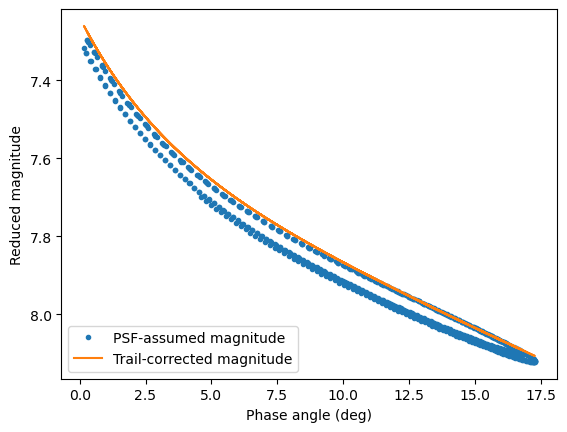

In [5]:
plt.plot(observations_df['phase_deg'], observations_df['trailedMagnitude']- 5 * np.log10(observations_df['Range_LTC_km'] * observations_df['Obj_Sun_LTC_km']/(1.495978707e8**2)), '.', label='PSF-assumed magnitude')
plt.plot(observations_df['phase_deg'], observations_df['HG_mag'] - 5 * np.log10(observations_df['Range_LTC_km'] * observations_df['Obj_Sun_LTC_km']/(1.495978707e8**2)), '-', label='Trail-corrected magnitude')

plt.xlabel('Phase angle (deg)')
plt.ylabel('Reduced magnitude')
plt.legend(loc=3)
plt.gca().invert_yaxis()
plt.show()

Using the wrong value will produce an offset in the recovered coefficients of the phase function (both $H$ and $G$). To show this, we will use an independent implementation (see the `demo_ApparentMagnitudeValidation` notebook) of the HG phase curve model and do a simplified fit the $G$ coefficient in both cases.

In [6]:
A = [3.332, 1.862]
B = [0.631, 1.218]
C = [0.986, 0.238]

def HG_model(phase, params):
    sin_a = np.sin(phase)
    tan_ah = np.tan(phase/2)
    
    W = np.exp(-90.56 * tan_ah * tan_ah)    
    scale_sina = sin_a/(0.119 + 1.341*sin_a - 0.754*sin_a*sin_a)
    
    phi_1_S = 1 - C[0] * scale_sina
    phi_2_S = 1 - C[1] * scale_sina
    
    phi_1_L = np.exp(-A[0] * np.power(tan_ah, B[0]))
    phi_2_L = np.exp(-A[1] * np.power(tan_ah, B[1]))
    
    phi_1 = W * phi_1_S + (1-W) * phi_1_L
    phi_2 = W * phi_2_S + (1-W) * phi_2_L
    return params[0] - 2.5*np.log10((1-params[1])* phi_1 + (params[1]) * phi_2) 

def chi2(params, mag, phase):
    pred = HG_model(phase, params)
    return (mag - pred)

def fit(mag, phase, params=[0.1]):
    from scipy.optimize import leastsq
    phase = np.deg2rad(phase)


    sol = leastsq(chi2, [mag[0]] + params,  (mag, phase), full_output = True)

    return sol[0]



Phase curve parameters from fitting for the reduced magnitude calculated from the PSF magnitude (which does not account for the source potentially having an extended PSF)

In [7]:
solution = fit(observations_df['HG_mag']- 5 * np.log10(observations_df['Range_LTC_km'] * observations_df['Obj_Sun_LTC_km']/(1.495978707e8**2)), observations_df['phase_deg'])

print(f'H = {solution[0]}, G = {solution[1]}')

H = 7.24, G = 0.19000000000000009


Phase curve parameters from fitting for the reduced magnitude calculated from the trailed source magnitude (which does account for the source being trailed due to motion of the simulated moving object during the ~30s LSST exposure.. 

In [8]:
solution = fit(observations_df['trailedMagnitude']- 5 * np.log10(observations_df['Range_LTC_km'] * observations_df['Obj_Sun_LTC_km']/(1.495978707e8**2)), observations_df['phase_deg'])

print(f'H = {solution[0]}, G = {solution[1]}')

H = 7.289904379246798, G = 0.22097131162112538


Both the estimated H and phase curve parameters will be offset if one incorrectly uses the PSF mag instead of the trailed soure mag. 